---
# [추가 분석] 지역별 배송 민감도 및 리뷰 하락 메커니즘 (한글 폰트 최적화 버전)

이 셀은 환경에 맞는 한글 폰트를 자동으로 설정하고 심화 분석을 수행합니다.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 1. 한글 폰트 설정 (환경 자동 감지)
if platform.system() == 'Windows':
    # 윈도우 (로컬 아나콘다 등)
    plt.rc('font', family='Malgun Gothic')
elif 'google.colab' in str(get_ipython()):
    # 구글 코랩
    # !sudo apt-get install -y fonts-nanum
    # !sudo fc-cache -fv
    # !rm ~/.cache/matplotlib -rf
    plt.rc('font', family='NanumBarunGothic')
else:
    # 맥(Darwin) 또는 기타
    plt.rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
sns.set_theme(style="whitegrid", font=plt.rcParams['font.family'])

path = 'c:/Users/judy4/Downloads/data/'

# 2. 데이터 로드 로직 (기존과 동일)
if 'df_main' not in locals():
    try: 
        orders = pd.read_csv(path + 'olist_orders_dataset.csv')
        reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
        customers = pd.read_csv(path + 'olist_customers_dataset.csv')
        
        orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
        orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
        
        df_main = orders[orders['order_status'] == 'delivered'].dropna(subset=['order_delivered_customer_date']).copy()
        df_main['delivery_delay_days'] = (df_main['order_delivered_customer_date'] - df_main['order_estimated_delivery_date']).dt.total_seconds() / 86400
        df_main = df_main.merge(reviews[['order_id', 'review_score']], on='order_id', how='inner')
        df_main = df_main.merge(customers[['customer_id', 'customer_state']], on='customer_id', how='left')
    except Exception as e:
        print(f"파일 로드 중 에러 발생: {e}")

df_deep = df_main[(df_main['delivery_delay_days'] >= -20) & (df_main['delivery_delay_days'] <= 50)].copy()
print("분석 준비 완료 및 폰트 설정 적용됨")

분석 준비 완료 및 폰트 설정 적용됨


### 1. 지연 시간에 따른 만족도 하락 곡선

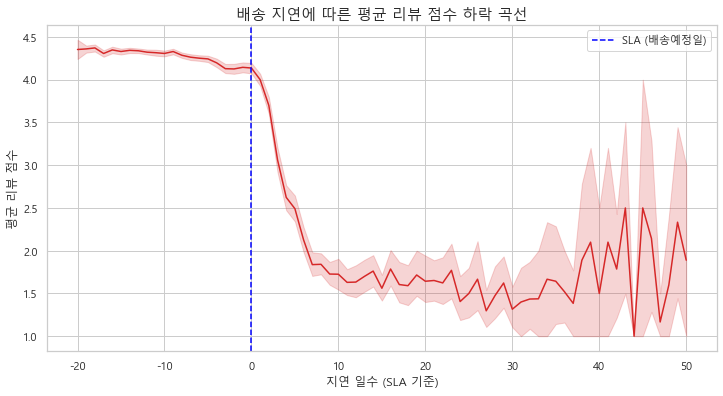

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_deep, x=df_deep['delivery_delay_days'].round(), y='review_score', color='#d62828')
plt.axvline(0, color='blue', linestyle='--', label='SLA (배송예정일)')
plt.title('배송 지연에 따른 평균 리뷰 점수 하락 곡선', fontsize=15)
plt.ylabel('평균 리뷰 점수')
plt.xlabel('지연 일수 (SLA 기준)')
plt.legend()
plt.show()

### 2. 지역별 지연 구간 만족도 히트맵

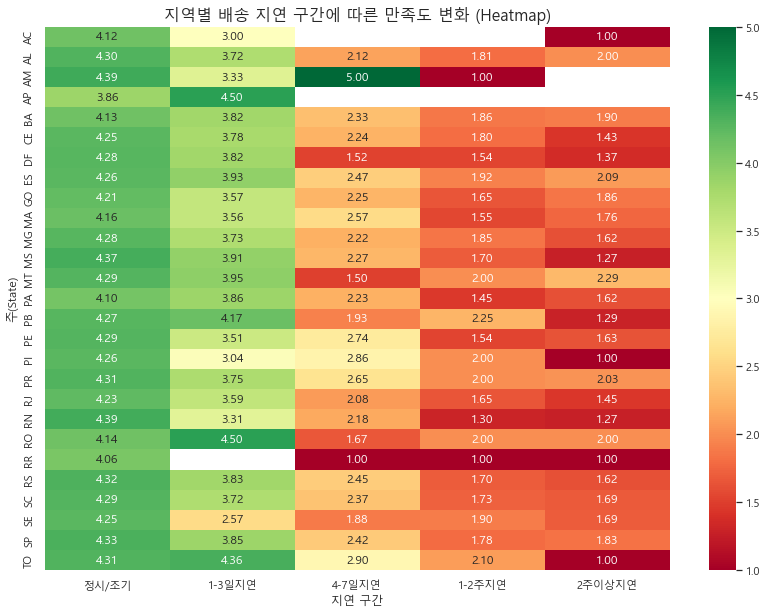

In [7]:
bins = [-30, 0, 3, 7, 14, 100]
labels = ['정시/조기', '1-3일지연', '4-7일지연', '1-2주지연', '2주이상지연']
df_deep['delay_group'] = pd.cut(df_deep['delivery_delay_days'], bins=bins, labels=labels)

state_heatmap = df_deep.pivot_table(index='customer_state', columns='delay_group', 
                                    values='review_score', aggfunc='mean')

plt.figure(figsize=(14, 10))
sns.heatmap(state_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', center=3)
plt.title('지역별 배송 지연 구간에 따른 만족도 변화 (Heatmap)', fontsize=16)
plt.xlabel('지연 구간')
plt.ylabel('주(State)')
plt.show()